# Clustering: More Examples and Topics

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as sk_data
import sklearn.metrics as metrics

import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import seaborn as sns

#import matplotlib as mpl
import seaborn as sns
%matplotlib inline

We set up our data set and other derived results to match those of the previous lecture.

In [3]:
(X, y) = sk_data.make_blobs(n_samples=100, centers=3, n_features=30,
                            center_box=(-10.0, 10.0),random_state=0)

euclidean_dists = metrics.euclidean_distances(X)
X

array([[ 0.76932537,  3.62569187,  2.80925899, ...,  8.23276975,
         0.64681591, -2.9473858 ],
       [-6.4446809 , -8.70609169,  3.93633252, ..., -7.54857643,
         0.65771436,  8.07632882],
       [-6.34769507,  4.75136098,  1.27258118, ..., -5.10636874,
         0.05656725, -4.00690969],
       ...,
       [-5.49981394, -9.08449843,  2.6079131 , ..., -6.16162778,
         2.46124422,  6.58079852],
       [-6.41629398, -7.2881536 ,  1.98261109, ..., -8.41378399,
         3.21627639,  8.01932093],
       [-5.00936654,  5.12964506, -2.76935525, ..., -4.31770864,
        -0.13718802, -4.7067927 ]])

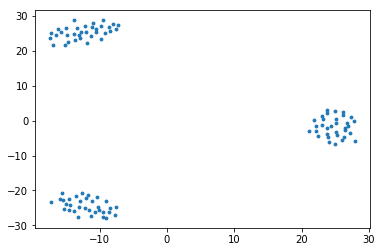

In [4]:
import sklearn.manifold
mds = sklearn.manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=0,
                   dissimilarity="precomputed", n_jobs=1)
fit = mds.fit(euclidean_dists)
pos = fit.embedding_
_ = plt.scatter(pos[:, 0], pos[:, 1], s=8)

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=100)
kmeans.fit_predict(X)

array([1, 2, 0, 0, 2, 1, 2, 2, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1, 0, 2, 0, 2,
       0, 1, 2, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 2, 0, 2, 2, 2, 1, 0,
       1, 0, 1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 2, 1, 1, 2,
       0, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 1, 2, 1, 2, 2, 2, 1, 0, 0, 2, 1,
       1, 0, 1, 2, 2, 0, 1, 0, 0, 2, 2, 0], dtype=int32)

In [6]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

### More on visualizing clustering results

We will first visualize the results by reordering the data entries according to their assigned cluster. Note that without this reordering, it is more difficult to identify visually what vectors in the same cluster may have in common.

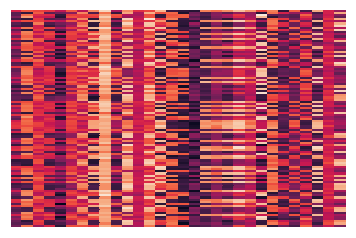

In [14]:
_ = sns.heatmap(X, xticklabels=False, yticklabels=False, linewidths=0, cbar=False)

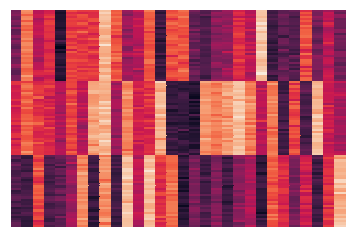

In [15]:
idx = np.argsort(labels) # Returns array of indices that index data in sorted order.
rX = X[idx, :] # Reorders the entries of X.
_ = sns.heatmap(rX, xticklabels=False, yticklabels=False, linewidths=0, cbar=False)

We can similarly reorder the distances. This allows us to see that vectors within the same cluster are closer to one another than to vectors in other clusters.

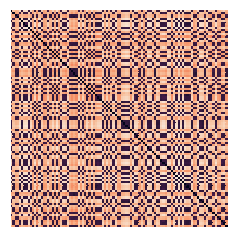

In [17]:
sns.heatmap(euclidean_dists, xticklabels=False, yticklabels=False, linewidths=0, square=True,cbar=False)

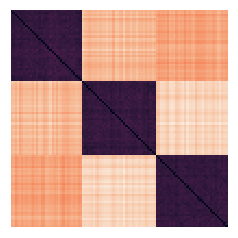

In [18]:
rearranged_dists = euclidean_dists[idx,:][:,idx] # Reorders the distance matrix.
sns.heatmap(rearranged_dists, xticklabels=False, yticklabels=False, linewidths=0, square=True,cbar=False)

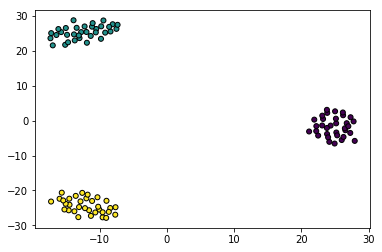

In [19]:
plt.scatter(pos[:, 0], pos[:, 1], marker='o', c=labels,
            s=25, edgecolor='k')

## Deciding on the number of clusters

So far, we have assumed that the number of clusters is given or known in advance. This is often not the case in unsupervised settings. In fact, the number of clusters may be one of the desired inputs of the analysis.

In practice, when using $k$-means or most other clustering methods, we must choose the number of clusters via some other process.

### Inspecting the Clustering Error 

The first thing you might do is to look at the $k$-means objective function (which is considered the clustering **error**) and see if it levels off after a certain value of $k$. If it levels off, this suggests that the clustering of the data points is not improving as the number of clusters is increased.

How do we expect the clustering error to change as $k$ varies?
* increase for all $k$ as $k$ increases
* decrease for all $k$ as $k$ increases
* increase for $k\leq 3$ then level off for $k\geq 3$
* decrease  for $k\leq 3$ then level off for $k\geq 3$
* increase for $k\leq 3$ then decrease for $k\geq 3$
* decrease  for $k\leq 3$ then increase for $k\geq 3$

In [20]:
error = np.zeros(11)
for k in range(1,11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(X)
    error[k] = kmeans.inertia_

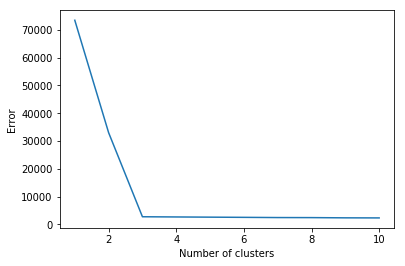

In [21]:
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
dummy = plt.ylabel('Error')

Note that this synthetic data is not at all typical. You will almost never see such a sharp change in the error function as we see above.

Let's create a function for later use that plots the error against the number of clusters for a given data set.

In [22]:
def evaluate_clusters(X, max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

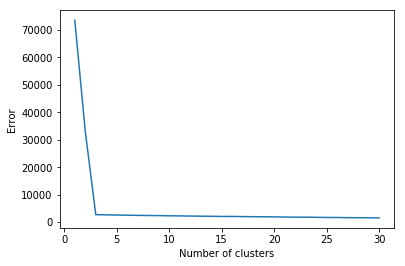

In [23]:
evaluate_clusters(X, 30)

### Rand Index

The **Rand index** is a simple similarity measure for clusterings. We can use it to measure the similarity between two clusterings. Alternatively, if we are testing an algorithm on data for which we know ground truth, we can use it to assess the algorithm's accuracy.

Let $n$ be the number of data points. Let $T$ be a ground truth label assignment to data points and let $C$ be label assignment obtained via a clustering algorithm.

Let $a$ be the number of pairs of elements that have the same label in $T$ and the same label in $C$. Let $b$ be the number of pairs of elements that have different labels in $T$ and different labels in $C$. Then the Rand index is defined to be:

$$ \mbox{R}(T,C) = \frac{a+b}{{n \choose 2}}$$

What are the largest and smallest possible values of the Rand index for a clustering?
* Between $-\infty$ and $+\infty$.
* Between $-1$ and $+\infty$
* Between $0$ and $+\infty$
* Between $-\infty$ and $1$
* Between $-1$ and $1$
* Between $0$ and $1$

### Adjusted Rand Index

The Rand index is not guaranteed to be close to zero for random label assignments (especially if the number of clusters is in the same order of magnitude as the number of samples).

To counter this effect we can use the expected Rand index $E[\text{R}]$ of random labelings to define the adjusted Rand index as follows:

\begin{equation}
\text{ARI} = \frac{\text{R} - E[\text{R}]}{\max(\text{R}) - E[\text{R}]}
\end{equation}

The computation of the expected RI requires fairly straightforward combinatorics.

What are the smallest and largest possible values of the ARI?
* Between $-\infty$ and $+\infty$.
* Between $-1$ and $+\infty$
* Between $0$ and $+\infty$
* Between $-\infty$ and $1$
* Between $-1$ and $1$
* Between $0$ and $1$

In [24]:
ri = metrics.adjusted_rand_score(labels, y)
print(ri)

1.0


We define a function to evaluate clusterings using the ARI.

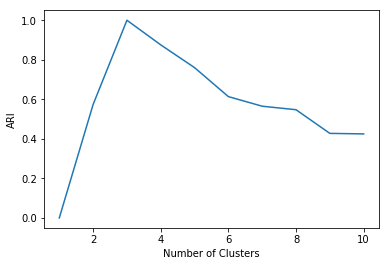

In [25]:
def ri_evaluate_clusters(X,max_clusters,ground_truth):
    ri = np.zeros(max_clusters+1)
    ri[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        ri[k] = metrics.adjusted_rand_score(kmeans.labels_,ground_truth)
    plt.plot(range(1,len(ri)),ri[1:])
    plt.xlabel('Number of Clusters')
    plt.ylabel('ARI')
    
ri_evaluate_clusters(X, 10, y)

As before, this type of clear choice for $k$ is unusual when working with real data sets.

### Silhouette Coefficient

Normally, the ground truth labels are not known. In that case, evaluation must be performed using the model itself. 

The **silhouette coefficient** (__`sklearn.metrics.silhouette_score`__) is an example of such an evaluation, where a higher value relates to a model with "better defined" clusters.

**Definition:** Let $a$ be the mean distance between a data point and all other points in the same cluster. Let $b$ be the mean distance between a data point and all other points in the next nearest cluster. Then the 
**silhouette coefficient** for a clustering is defined to be:

$$s = \frac{b - a}{\max(a, b)}$$

In [26]:
sc = metrics.silhouette_score(X, labels, metric='euclidean')
print(sc)

0.8319348841402534


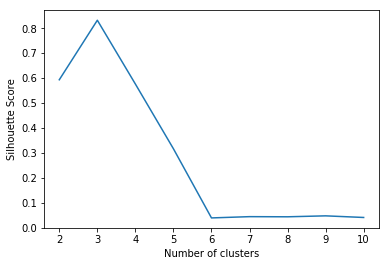

In [27]:
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='euclidean')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    
sc_evaluate_clusters(X,10)

As before, these results are more perfect than they would be for typical real-world data. But the general idea is to look for a local maximum in the silhouette coefficient as the potential number of clusters grows.

## Examples with Real Data

As a "real world" example, we'll use the ["20 Newsgroup" data set](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#loading-the-20-newsgroups-dataset) provided as an example data set in scikit-learn.

In [28]:
from sklearn.datasets import fetch_20newsgroups

"""
categories = [
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'talk.religion.misc',
 'comp.graphics',
 'sci.space',
 'rec.autos',
 'rec.sport.baseball'
]
"""
categories = ['comp.os.ms-windows.misc', 'sci.space','rec.sport.baseball']
news_data = fetch_20newsgroups(subset='train', categories=categories)
print(news_data.target, len(news_data.target))
print(news_data.target_names)

[2 0 0 ... 2 1 2] 1781
['comp.os.ms-windows.misc', 'rec.sport.baseball', 'sci.space']


In [29]:
news_data.data[18] # There are 1781 entries like this one.

'From: 8725157m@levels.unisa.edu.au\nSubject: Cold gas roll control thruster tanks\nOrganization: University of South Australia\nLines: 5\n\nDoes anyone know how to size cold gas roll control thruster tanks\nfor sounding rockets?\n\nThanks in advance,\nJim.\n'

### Feature Extraction

We have discussed some of the challenges of feature engineering. One of the most basic issues is how to encode categorical or text data in a form usable by algorithms that expect numeric input.

As we have discussed earlier, one can encode a set using a binary vector with one component for each potential set member.

There is also the _bag of words_ encoding for a document, where the document is represented as a **multi**set of words. To obtain a representation for a document, we simply count how many times each word occurs (it is a "bag" because all the order of the words in the document is lost).

Surprisingly, we can still tell a lot about the document even without knowing the order of the words in it. Counting the number of times each word occurs in a document yields a vector of __term frequencies__.

However, simply using the "bag of words" directly has a number of drawbacks.   First of all, large documents will have more words than small documents. Hence it often makes sense to normalize the frequency vectors (i.e., using a metric).

Next, as noted in __scikit-learn__:

>In a large text corpus, some words will be very [frequent] (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. 

>If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.


>In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

>__Tf__ means __term-frequency__ while __tf–idf__ means __term-frequency times inverse document-frequency.__

>This is a originally a term weighting scheme developed for information retrieval (as a ranking function for search engines results), that has also found good use in document classification and clustering.

The idea is that rare words are more informative than common words.  (This has connections to information theory).

Hence, the definition of tf-idf is as follows.

First:

$$\text{tf}(t,d) = \text{Number of times term }t \text{ occurs in document } d$$

Next, if $N$ is the total number of documents in the corpus $D$ then:

$$\text{idf}(t,D)=\frac{N}{|\{d\in D : t\in d \}|}$$

where the denominator is the number of documents in which the term $t$ appears.

And finally:

$$\text{tf-idf}(t,d)=\text{tf}(t,d)\times \text{idf}(t,D)$$

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df=4, max_df=0.8)
data = vectorizer.fit_transform(news_data.data)
data

<1781x9409 sparse matrix of type '<class 'numpy.float64'>'
	with 159529 stored elements in Compressed Sparse Row format>

### Understanding the Data

In [31]:
print(type(data), data.shape) # There are 9409 counts for each of 1781 documents.

<class 'scipy.sparse.csr.csr_matrix'> (1781, 9409)


In [32]:
len(data.todense().tolist()[0])

9409

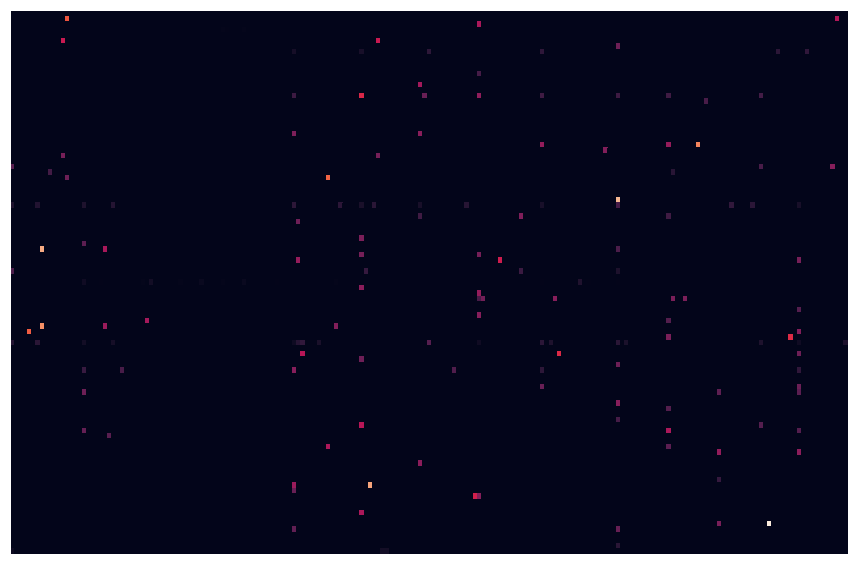

In [33]:
# We plot the first 200 counts for 100 of the documents.
(fig, ax1) = plt.subplots(1,1,figsize=(15,10))
dum = sns.heatmap(data[1:100,1:200].todense(), xticklabels=False, yticklabels=False, 
                  linewidths=0, cbar=False, ax=ax1)

In [34]:
print(np.max(data[5, :]))
print(np.argmax(data[5, :]))

0.2963422829315451
8626


In [35]:
data[5, 8626]
terms = vectorizer.get_feature_names()
print(terms[8626])

udel


In [36]:
print(news_data.target)
print(news_data.target_names)

[2 0 0 ... 2 1 2]
['comp.os.ms-windows.misc', 'rec.sport.baseball', 'sci.space']


### Selecting the number of clusters

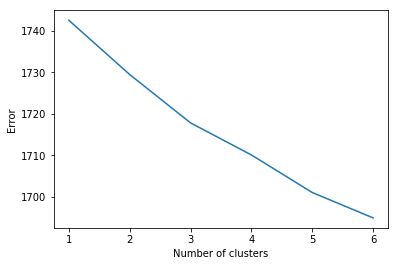

In [41]:
evaluate_clusters(data, 6)

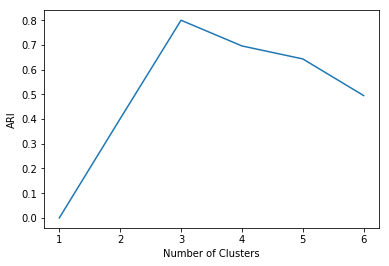

In [42]:
ri_evaluate_clusters(data,6,news_data.target) # Compare to the true labels.

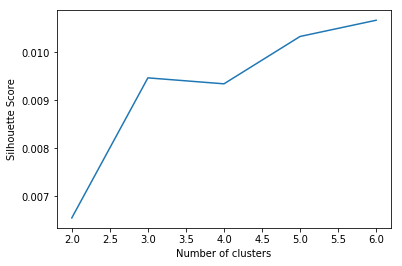

In [43]:
sc_evaluate_clusters(data,6) # Compare inter- and intra-cluster distances.

### Inspecting the clusters

In [29]:
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit_predict(data)

array([1, 2, 2, ..., 0, 1, 0], dtype=int32)

In [30]:
print("Top terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()
order_centroids = asc_order_centroids[:,::-1] # Reverse order using ::-1.
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster {}:".format(i))
    for ind in order_centroids[i, :10]:
        print(' {}'.format(terms[ind]))
    print('')

Top terms per cluster:
Cluster 0:
 space
 nasa
 edu
 henry
 access
 alaska
 gov
 digex
 moon
 com

Cluster 1:
 edu
 com
 year
 baseball
 writes
 article
 team
 game
 cs
 university

Cluster 2:
 windows
 edu
 file
 dos
 com
 files
 driver
 card
 use
 drivers



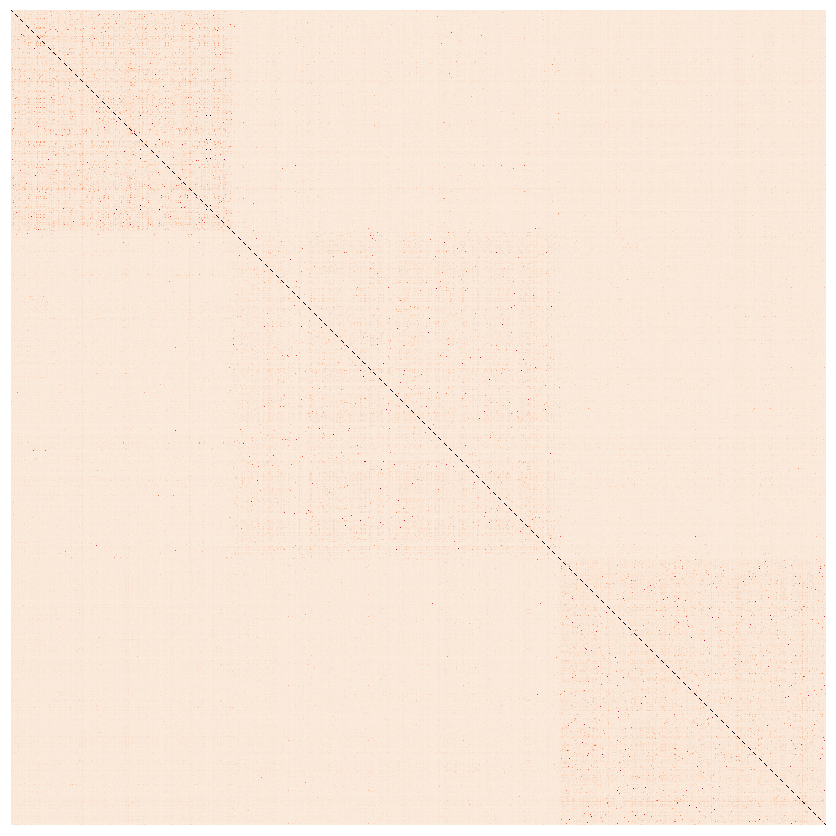

In [34]:
euclidean_dists = metrics.euclidean_distances(data)
labels = kmeans.labels_
idx = np.argsort(labels)
clustered_dists = euclidean_dists[idx][:,idx]
fig, ax1 = plt.subplots(1,1,figsize=(15,15))
dum = sns.heatmap(clustered_dists, xticklabels=False, yticklabels=False, linewidths=0, square=True,cbar=False, ax=ax1)